In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from csv import DictWriter

import seaborn as sns


from investigation_functions import  test_table_funcs as ttf
from investigation_functions import ml_funcs as mlf
from investigation_functions import ml_visualisation_funcs as mvf


## Functions and data gathering

In [43]:
n_qubits_list = [4,8,16]
backends_list = ['brisbane','torino']
circuits_list = ['1','2','3']
exp_type_list = ['Hardware','Refreshed_Hardware', 'Simulated','Refreshed_Simulated']


In [44]:
def get_test_list(
        qubits_list,change,
        backends_list = ['brisbane','torino','fez','marrakesh'],
        circuits_list = ['1','2','3'],
        exp_type_list = ['Hardware', 'Simulated','Refreshed_Simulated']
    ):
    
    backend_same =list(zip(backends_list,backends_list))
    circuit_same =list(zip(circuits_list,circuits_list))
    exp_type_same=list(zip(exp_type_list,exp_type_list))

    exp_type_pairs_ = exp_type_same
    circuit_pairs_ = circuit_same
    backend_pairs_ = backend_same

    if change == 'exp_type':
        exp_type_pairs_ =  list(combinations(exp_type_list, 2))
    elif change == 'circuits':
        circuit_pairs_ =  list(combinations(circuits_list, 2))
    elif change == 'backends':
        backend_pairs_ = list(combinations(backends_list, 2))
    else:
        raise('invalid change variable')
    

    test_combos = []

    
    for exp_type_pair in exp_type_pairs_:
    
        for nr_qubits in qubits_list:

            for circuit_pair in circuit_pairs_:

                for backend_pair in backend_pairs_:

                    row = {
                        'exp_type_pair':exp_type_pair,
                        'nr_qubits':nr_qubits,
                        'circuit_pair':circuit_pair,
                        'backend_pair':backend_pair
                    }
                    test_combos.append(row)
    
    return test_combos
def get_df_file_path_from_row(test_row, dir_runs, df_nr = 1):
    index = df_nr-1
    nq = str(test_row['nr_qubits'])
    exp_t =test_row['exp_type_pair'][index]
    circ = str(test_row['circuit_pair'][index])

    #get csv file_name
    file_name = nq + "q_"
    if 'Hardware' in exp_t:
        file_name = file_name +"ibm_"+test_row['backend_pair'][index]
    else:
        file_name = file_name +"fake_"+test_row['backend_pair'][index]
    file_name = file_name +circ+".csv"

    #get file path
    file_path = dir_runs + exp_t +"_results/" 
    file_path = file_path+ nq+"q/"
    file_path = file_path + file_name

    return file_path


def load_test_dfs_from_test_row(test_row,dir_runs):
    df1_file_name = get_df_file_path_from_row(test_row,dir_runs,1)
    df2_file_name = get_df_file_path_from_row(test_row,dir_runs,2)

    df1 = pd.read_csv(df1_file_name)
    df2 = pd.read_csv(df2_file_name)

    return df1,df2

def get_and_record_corr_from_test_row(test_row, file_name,dir_corr,dir_runs):
    df1,df2 = load_test_dfs_from_test_row(test_row,dir_runs)
    corr_avg = df1.corrwith(df2).mean()
    
    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg"
    ]
    
    row = {
        "nr_qubits":test_row['nr_qubits'],
        "exp_type 1":test_row['exp_type_pair'][0],
        "exp_type 2":test_row['exp_type_pair'][1],
        "backend 1":test_row['backend_pair'][0],
        "backend 2":test_row['backend_pair'][1],
        "circuit 1":test_row['circuit_pair'][0],
        "circuit 2":test_row['circuit_pair'][1],
        "corr avg":corr_avg
    }
    with open(dir_corr+file_name, 'a', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writerow(row)

def create_corr_csv(file_name,dir_corr):
    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg"
    ]
    with open(dir_corr+file_name, 'w', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writeheader()

def get_and_record_corrs_from_tests_list(tests_list,file_name,dir_corr,dir_runs,create_csv = False):
    fields = [
        "nr_qubits","exp_type 1","exp_type 2",
        "backend 1","backend 2","circuit 1","circuit 2",
        "corr avg"
    ]
    if create_csv:
        create_corr_csv(file_name, dir_corr)
    
    for test_row in tests_list:
        get_and_record_corr_from_test_row(test_row,file_name,dir_corr,dir_runs)
    

In [ ]:
dir_corr = "../Corr_results/with_refr_H/"
file_name = "4q_bvb.csv"
dir_runs = "../"

qubits_list = [4]
# can change 'backends', 'circuits', 'exp type'
tests_list_bvb = get_test_list(
    qubits_list, change = 'backends',
    backends_list=backends_list,
    exp_type_list=exp_type_list)

get_and_record_corrs_from_tests_list(
    tests_list_bvb,file_name,dir_corr,dir_runs,create_csv=True
)

def combine_cols(corr_df):
    new_df = corr_df

    exps = new_df.loc[:,'exp_type 1':'exp_type 2'].apply(np.unique,axis=1)
    new_df['exp types'] = exps.apply(" ".join)

    circs = new_df.loc[:,'circuit 1':'circuit 2'].astype(str)
    circs = circs.apply(np.unique,axis=1)
    new_df['circuits'] = circs.apply(" ".join)

    backs = new_df.loc[:,'backend 1':'backend 2'].apply(np.unique,axis=1)
    new_df['backends'] = backs.apply(" ".join)

    new_df.drop(
        [
            'exp_type 1','exp_type 2','circuit 1','circuit 2',
            'backend 1','backend 2'
        ],
        axis=1,inplace = True)

    return new_df
    # ", ".join(my_tuple)
def add_corr_mag(df):
    df_ = df
    df_['corr avg mag']=df_['corr avg'].apply(abs)
    return df

## Exp type plotting

In [46]:
df_4q_exp_t = pd.read_csv(dir_corr+"4q_exp_types.csv")
df_8q_exp_t = pd.read_csv(dir_corr+"8q_exp_types.csv")
# df_16q_exp_t = pd.read_csv(dir_corr+"16q_exp_type.csv")

exp_type_dfs = [df_4q_exp_t,df_8q_exp_t]#,df_16q_exp_t] 

In [47]:
df_4q_exp_t.head(2)

,nr_qubits,exp_type 1,exp_type 2,backend 1,backend 2,circuit 1,circuit 2,corr avg
0,4,Hardware,Refreshed_Hardware,brisbane,brisbane,1,1,-0.000914
1,4,Hardware,Refreshed_Hardware,torino,torino,1,1,0.083854


In [ ]:
exp_dfs = []
for q in exp_type_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    exp_dfs.append(newq)
exp_dfs[0].head(2)

,nr_qubits,corr avg,exp types,circuits,backends,corr avg mag
0,4,-0.000914,Hardware Refreshed_Hardware,1,brisbane,0.000914
1,4,0.083854,Hardware Refreshed_Hardware,1,torino,0.083854
2,4,-0.010892,Hardware Refreshed_Hardware,2,brisbane,0.010892
3,4,-0.069598,Hardware Refreshed_Hardware,2,torino,0.069598
4,4,0.009457,Hardware Refreshed_Hardware,3,brisbane,0.009457
5,4,-0.010934,Hardware Refreshed_Hardware,3,torino,0.010934
6,4,0.081313,Hardware Simulated,1,brisbane,0.081313
7,4,-0.153477,Hardware Simulated,1,torino,0.153477
8,4,0.146243,Hardware Simulated,2,brisbane,0.146243
9,4,0.027920,Hardware Simulated,2,torino,0.027920


In [50]:
# refr_H_dfs = exp_types.str.contains('Refreshed_Hardware')


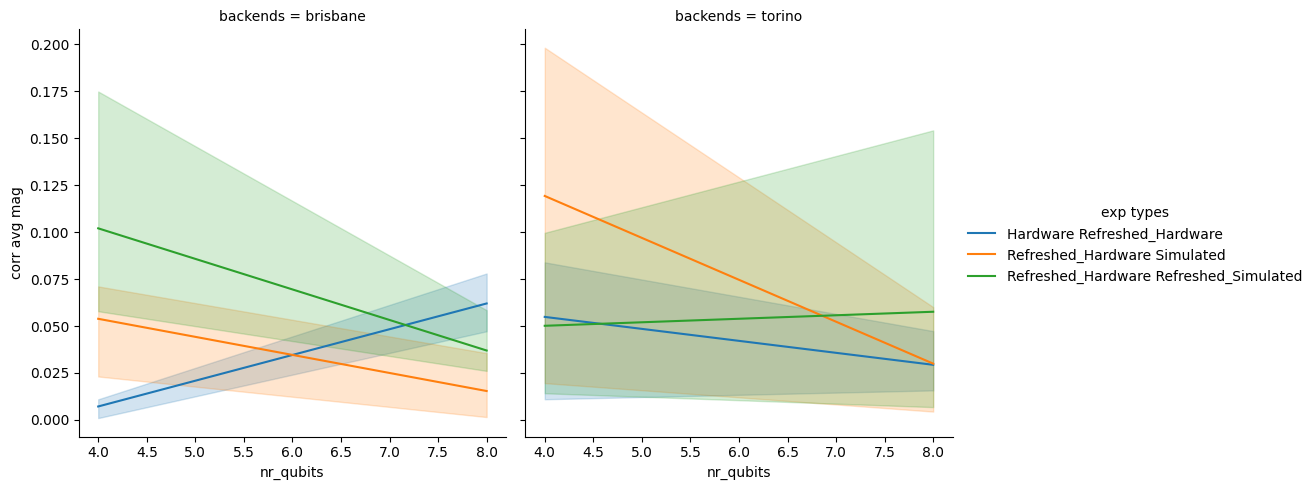

In [51]:
all_dfs =pd.concat(exp_dfs)

sns.relplot(
    data = all_dfs[all_dfs['exp types'].str.contains('Refreshed_Hardware')],
    x= 'nr_qubits',
    y = 'corr avg mag',
    hue = 'exp types',
    col = 'backends',
    # row = 'circuits',
    kind = 'line',
    col_wrap = 2,
    height = 5,
    aspect = 1
)

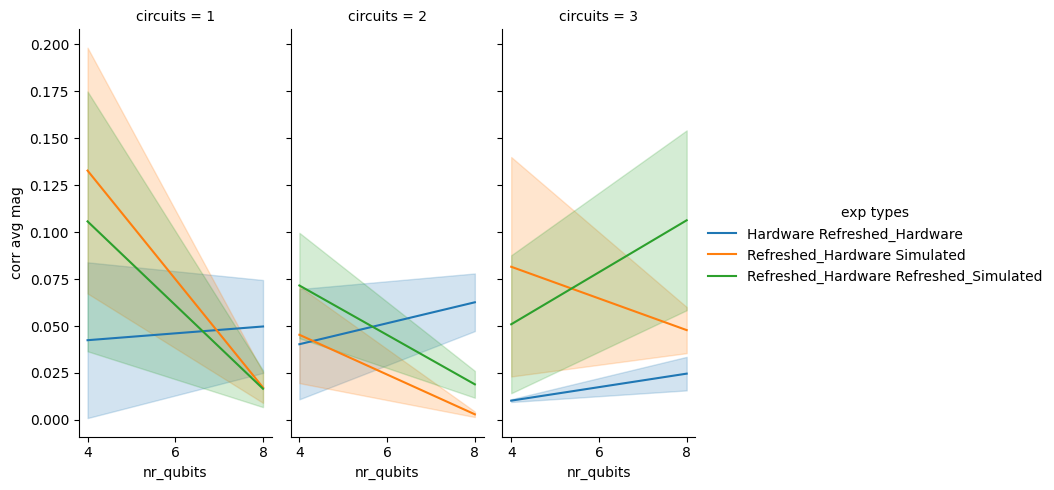

In [52]:
sns.relplot(
    data = all_dfs[all_dfs['exp types'].str.contains('Refreshed_Hardware')],
    x= 'nr_qubits',
    y = 'corr avg mag',
    hue = 'exp types',
    # col = 'backends',
    col = 'circuits',
    kind = 'line',
    height = 5,
    aspect = 0.5
)

## Backend vs Backend plotting

In [59]:
df_4q_bvb = pd.read_csv(dir_corr+"4q_bvb.csv")
df_8q_bvb = pd.read_csv(dir_corr+"8q_bvb.csv")
# df_16q_bvb = pd.read_csv(dir_corr+"16q_backends_vs_backends.csv")

bvb_dfs = [df_4q_bvb,df_8q_bvb]#,df_16q_bvb] 

bvb_dfs_p = []
for q in bvb_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    bvb_dfs_p.append(newq)

Text(0.5, 1.05, 'brisbane vs torino correlations')

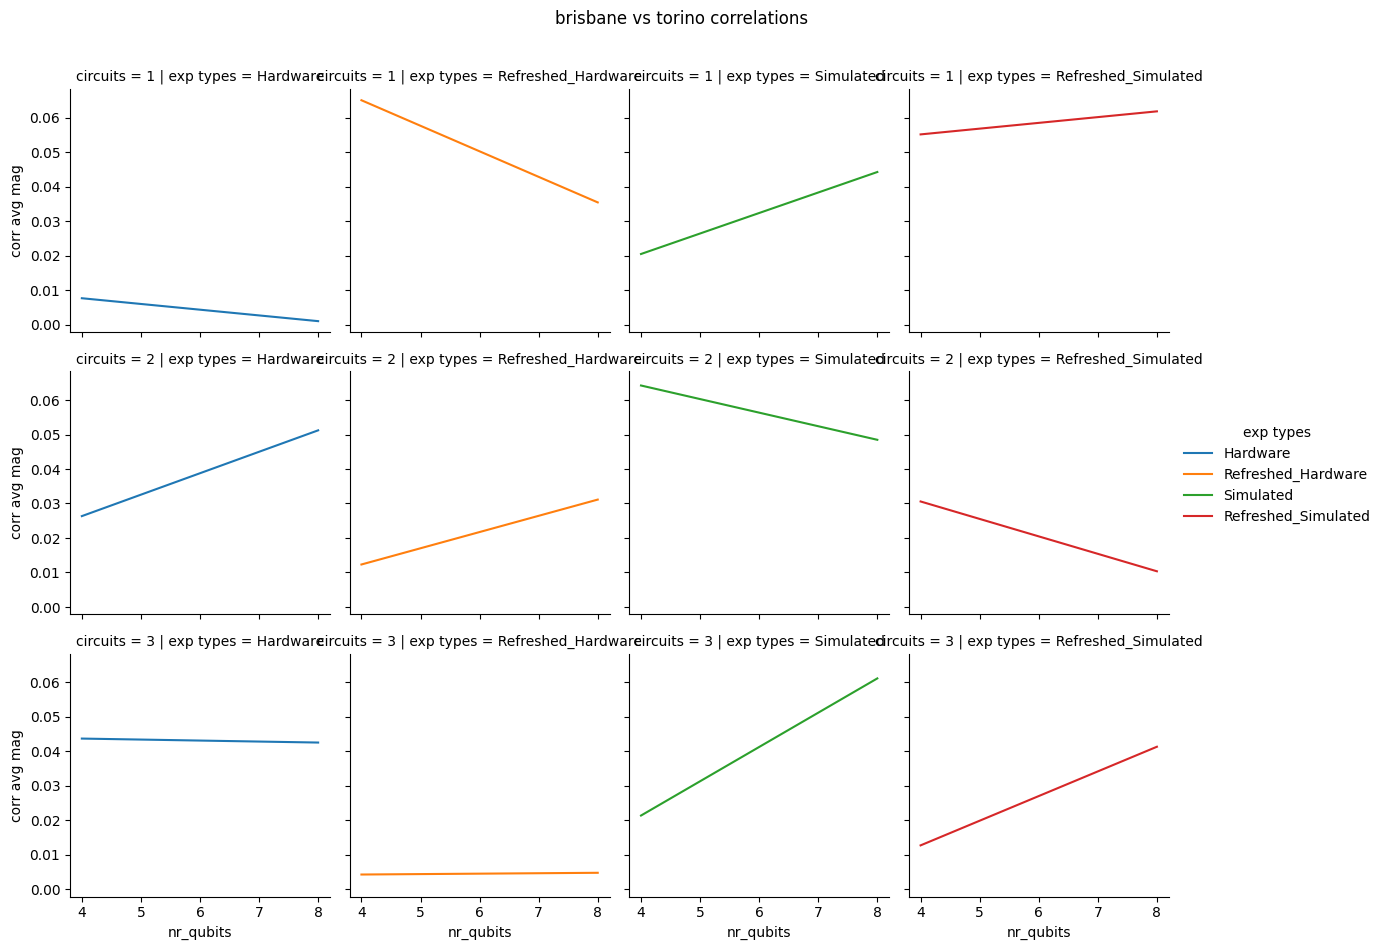

In [66]:

sns.relplot(
    data = pd.concat(bvb_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    col = 'exp types',
    # col_wrap = 3,
    hue = 'exp types',
    row = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)
plt.suptitle('brisbane vs torino correlations',y=1.05)

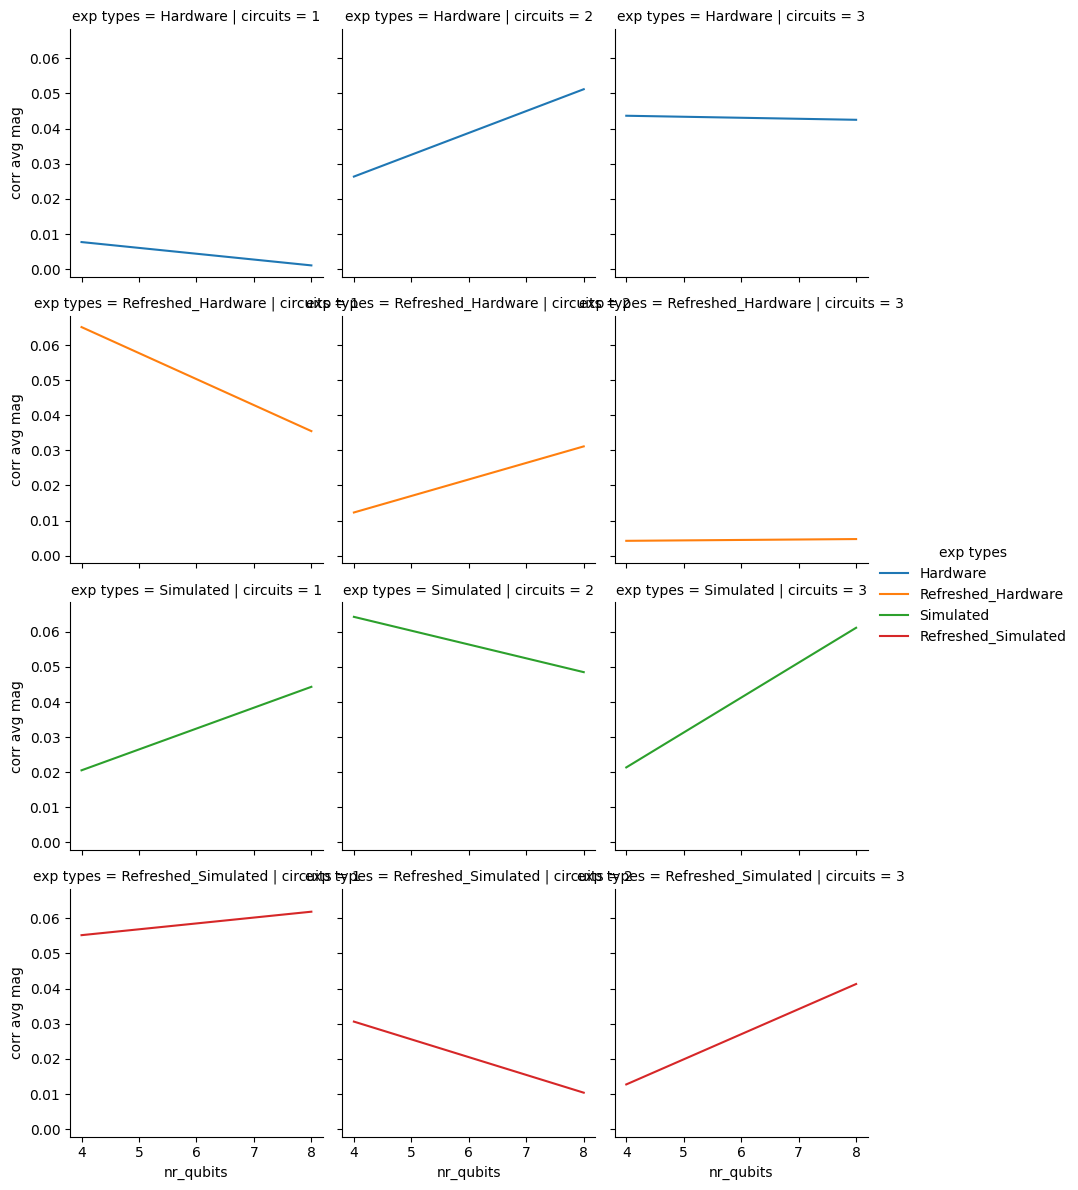

In [71]:
sns.relplot(
    data = pd.concat(bvb_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    col = 'circuits',
    # col_wrap = 3,
    hue = 'exp types',
    row = 'exp types',
    # hue = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

## Circuits vs Circuits

In [72]:
df_4q_cvc = pd.read_csv(dir_corr+"4q_circs.csv")
df_8q_cvc = pd.read_csv(dir_corr+"8q_circs.csv")
# df_16q_cvc = pd.read_csv(dir_corr+"16q_circuits_table.csv")

cvc_dfs = [df_4q_cvc,df_8q_cvc]#,df_16q_cvc] 

cvc_dfs_p = []
for q in cvc_dfs:
    newq =combine_cols(q)
    newq = add_corr_mag(newq)
    cvc_dfs_p.append(newq)

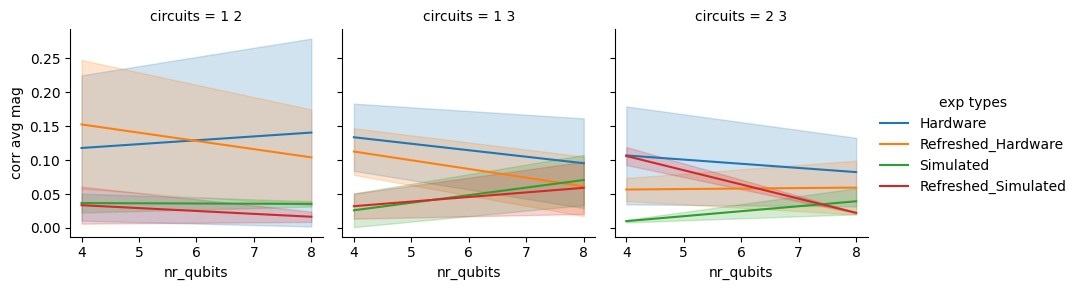

In [73]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    # col = 'backends',
    col_wrap = 3,
    hue = 'exp types',
    col = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)

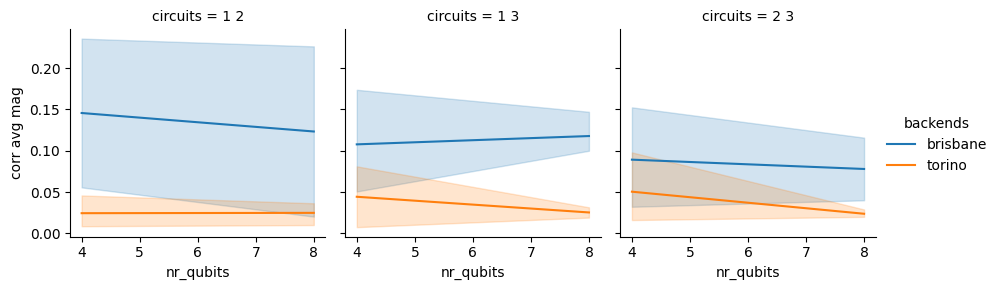

In [74]:
sns.relplot(
    data = pd.concat(cvc_dfs_p),
    x= 'nr_qubits',
    y = 'corr avg mag',
    # col = 'backends',
    col_wrap = 3,
    hue = 'backends',
    col = 'circuits',
    kind = 'line',
    height = 3,
    aspect = 1
)